In [84]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense,Dropout
import matplotlib.pyplot as plt
from keras.applications import VGG16
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
import tensorflow as tf
import cv2

In [115]:
%matplotlib inline

In [224]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    STYLE_IMAGE = 'images/stone_style.jpg' # Style image to use.
    CONTENT_IMAGE = 'images/content300.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'

In [272]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [273]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [268]:
model

{'avgpool1': <tf.Tensor 'AvgPool_15:0' shape=(1, 150, 200, 64) dtype=float32>,
 'avgpool2': <tf.Tensor 'AvgPool_16:0' shape=(1, 75, 100, 128) dtype=float32>,
 'avgpool3': <tf.Tensor 'AvgPool_17:0' shape=(1, 38, 50, 256) dtype=float32>,
 'avgpool4': <tf.Tensor 'AvgPool_18:0' shape=(1, 19, 25, 512) dtype=float32>,
 'avgpool5': <tf.Tensor 'AvgPool_19:0' shape=(1, 10, 13, 512) dtype=float32>,
 'conv1_1': <tf.Tensor 'Relu_48:0' shape=(1, 300, 400, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Relu_49:0' shape=(1, 300, 400, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Relu_50:0' shape=(1, 150, 200, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Relu_51:0' shape=(1, 150, 200, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Relu_52:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Relu_53:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Relu_54:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Relu_55:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv

In [278]:
def content_cost(a_G,a_C):
    m,n_h,n_w,n_c=a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(tf.reshape(a_C,[n_h*n_w,n_c]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,[n_h*n_w,n_c]))
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4*n_h*n_w*n_c)
    return J_content

In [255]:

def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)   
    return input_image
    

In [256]:
def gram_matrix(A):
    u=tf.matmul(A,tf.transpose(A))
    return u

In [92]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [275]:
def style_cost_layer(a_G,a_S):
    m,n_h,n_w,n_c=a_G.get_shape().as_list()
    a_GTr=tf.transpose(tf.reshape(a_G,[n_h*n_w,n_c]))
    a_STr=tf.transpose(tf.reshape(a_S,[n_h*n_w,n_c]))
    x=gram_matrix(a_GTr)
    y=gram_matrix(a_STr)
    cst=tf.reduce_sum(tf.square(tf.subtract(x,y)))/(4*n_h*n_h*n_w*n_w*n_c*n_c)
    return cst
    
    
    

In [270]:
#tf.reset_default_graph()
sess=tf.InteractiveSession()

In [259]:
def style_cost(model,STYLE_LAYERS):
    J_style=0
    for layer_name,contr in STYLE_LAYERS:
        output=model[layer_name]
        a_S=sess.run(output)
       # print(a_S.shape)
        a_G=output
        J_style=J_style+(style_cost_layer(a_G,a_S)*contr)
    return J_style

(300, 400, 3)


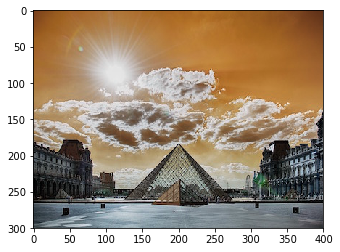

In [260]:
q1=cv2.imread("l1.jpg")

print(q1.shape)
plt.imshow(q1)

(300, 400, 3)
(1, 300, 400, 3)


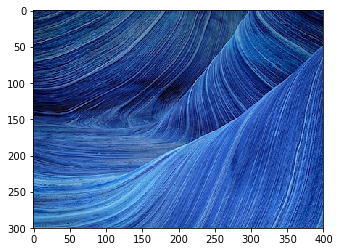

In [261]:

q1=np.array(q1)
q1=q1.reshape(1,300,400,3)
q2=cv2.imread("l2.jpg")
plt.imshow(q2)
q2=np.array(q2)
print(q2.shape)
q2=q2.reshape(1,300,400,3)
print(q2.shape)


In [262]:
conzero=q1-CONFIG.MEANS
stylo=q2-CONFIG.MEANS
genero=generate_noise_image(conzero) 

In [292]:
sess.run(model['input'].assign(conzero))
out = model['conv4_2']
a_C=sess.run(out)
a_G=out
J_contentz=content_cost(a_G,a_C)

In [293]:
sess.run(model['input'].assign(stylo))
J_stylez=style_cost(model,STYLE_LAYERS)

In [295]:
def total_cost(J_content,J_style,alpha=10,beta=40):
    lz=alpha*J_content+beta*J_style
    return lz

In [296]:
optimizer = tf.train.AdamOptimizer(2.0)
T_C=total_cost(J_contentz,J_stylez)
train_step = optimizer.minimize(T_C)

In [297]:
def workz(sess,input_image,epoch):
    
    
   
    sess.run(tf.global_variables_initializer())
    
    
    sess.run(model['input'].assign(input_image))
    for i in range(epoch):
        print(i)
        
        sess.run(train_step)
        generated_image = sess.run(model['input'])
        Jt, Jc, Js = sess.run([T_C, J_content, J_style])
        print("total cost = " + str(Jt))
        print("content cost = " + str(Jc))
        print("style cost = " + str(Js))
    return generated_image
        
        
        
        
        
    

In [298]:
xxx=workz(sess,genero,140)

0
total cost = 3.3183e+10
content cost = 7021.37
style cost = 8.29573e+08
1
total cost = 3.11127e+10
content cost = 7627.67
style cost = 7.77815e+08
2
total cost = 2.90511e+10
content cost = 8361.75
style cost = 7.26275e+08
3
total cost = 2.70688e+10
content cost = 9192.46
style cost = 6.76718e+08
4
total cost = 2.51949e+10
content cost = 10095.4
style cost = 6.2987e+08
5
total cost = 2.34808e+10
content cost = 11048.5
style cost = 5.87017e+08
6
total cost = 2.19345e+10
content cost = 12011.7
style cost = 5.4836e+08
7
total cost = 2.05408e+10
content cost = 12939.3
style cost = 5.13518e+08
8
total cost = 1.92621e+10
content cost = 13799.1
style cost = 4.81549e+08
9
total cost = 1.80663e+10
content cost = 14577.2
style cost = 4.51654e+08
10
total cost = 1.69486e+10
content cost = 15275.1
style cost = 4.23711e+08
11
total cost = 1.59203e+10
content cost = 15910.3
style cost = 3.98004e+08
12
total cost = 1.49959e+10
content cost = 16499.4
style cost = 3.74893e+08
13
total cost = 1.41811e+

total cost = 1.02138e+09
content cost = 25779.1
style cost = 2.55281e+07
110
total cost = 1.00694e+09
content cost = 25792.3
style cost = 2.51671e+07
111
total cost = 9.92838e+08
content cost = 25804.8
style cost = 2.48145e+07
112
total cost = 9.79073e+08
content cost = 25817.1
style cost = 2.44704e+07
113
total cost = 9.65686e+08
content cost = 25829.5
style cost = 2.41357e+07
114
total cost = 9.52636e+08
content cost = 25841.8
style cost = 2.38094e+07
115
total cost = 9.39883e+08
content cost = 25854.1
style cost = 2.34906e+07
116
total cost = 9.2741e+08
content cost = 25866.0
style cost = 2.31788e+07
117
total cost = 9.15258e+08
content cost = 25877.5
style cost = 2.2875e+07
118
total cost = 9.0339e+08
content cost = 25888.8
style cost = 2.25783e+07
119
total cost = 8.91776e+08
content cost = 25899.8
style cost = 2.22879e+07
120
total cost = 8.80394e+08
content cost = 25910.3
style cost = 2.20034e+07
121
total cost = 8.6924e+08
content cost = 25920.8
style cost = 2.17245e+07
122
tot

In [299]:
xxx.shape

(1, 300, 400, 3)

In [302]:
q=xxx+CONFIG.MEANS

In [336]:
 np.max(q[0])

349.14233862304684

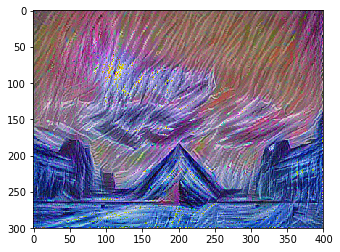

In [341]:
plt.imshow(abs(q[0]/255))

In [310]:
import cv2

In [314]:
cv2.imwrite("fuk1.jpg",abs(q[0]/25))

True

In [324]:
np.max(q[0]/355)

0.98349954541703333

In [328]:
plt.imsave("ZORO.png",abs(q[0]/355))

In [329]:
q2=cv2.imread("l2.jpg")

In [332]:
plt.imsave("xx.png",q2)